In [10]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [15]:
news_tables = {}
tickers = ['GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # print(html)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    # print(news_table)
    news_tables[ticker] = news_table

In [17]:
# Read one single day of headlines for 'GOOG' 
ggle = news_tables['GOOG']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
ggle_tr = ggle.findAll('tr')
# print(ggle_tr)
for i, table_row in enumerate(ggle_tr):
    # Read the text of the element 'a' into 'a_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'td_text'
    td_text = table_row.td.text
    # Print the contents of 'a_text' and 'td_text' 
    print(a_text)
    print(td_text)
    if i == 5:
        break

Google has created an AI-powered nightmare creature generator
Nov-17-20 06:18PM  
Biden Risks Ceding Asia's Digital Oil to China
06:00PM  
The Changing Face of Fitness
05:59PM  
ROSEN, A LEADING LAW FIRM, Announces Investigation of Securities Claims Against Alphabet Inc.; Encourages Investors with Losses in Excess of $100K to Contact the Firm - GOOG, GOOGL
05:53PM  
Senators say Facebook, Twitter moderation is a 'whack-a-mole problem' 'run amok'
05:50PM  
Zuckerberg, Dorsey Face Angry Lawmakers Still Split on Concerns
05:26PM  


In [26]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # split text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['GOOG',
  'Nov-17-20',
  '06:18PM',
  'Google has created an AI-powered nightmare creature generator'],
 ['GOOG',
  'Nov-17-20',
  '06:00PM',
  "Biden Risks Ceding Asia's Digital Oil to China"],
 ['GOOG', 'Nov-17-20', '05:59PM', 'The Changing Face of Fitness'],
 ['GOOG',
  'Nov-17-20',
  '05:53PM',
  'ROSEN, A LEADING LAW FIRM, Announces Investigation of Securities Claims Against Alphabet Inc.; Encourages Investors with Losses in Excess of $100K to Contact the Firm - GOOG, GOOGL'],
 ['GOOG',
  'Nov-17-20',
  '05:50PM',
  "Senators say Facebook, Twitter moderation is a 'whack-a-mole problem' 'run amok'"],
 ['GOOG',
  'Nov-17-20',
  '05:26PM',
  'Zuckerberg, Dorsey Face Angry Lawmakers Still Split on Concerns'],
 ['GOOG',
  'Nov-17-20',
  '03:07PM',
  'Soros Regrets Early Investment in Peter Thiels Palantir'],
 ['GOOG',
  'Nov-17-20',
  '12:05PM',
  'Kids on YouTube See Many Ads, Few Educational Videos: Study'],
 ['GOOG',
  'Nov-17-20',
  '11:02AM',
  'Dow Slips as Bulls Hit Pause on V

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,GOOG,2020-11-17,06:18PM,Google has created an AI-powered nightmare cre...,0.000,0.778,0.222,0.2500
1,GOOG,2020-11-17,06:00PM,Biden Risks Ceding Asia's Digital Oil to China,0.231,0.769,0.000,-0.2732
2,GOOG,2020-11-17,05:59PM,The Changing Face of Fitness,0.000,0.656,0.344,0.2732
3,GOOG,2020-11-17,05:53PM,"ROSEN, A LEADING LAW FIRM, Announces Investiga...",0.088,0.747,0.166,0.3400
4,GOOG,2020-11-17,05:50PM,"Senators say Facebook, Twitter moderation is a...",0.231,0.769,0.000,-0.4019


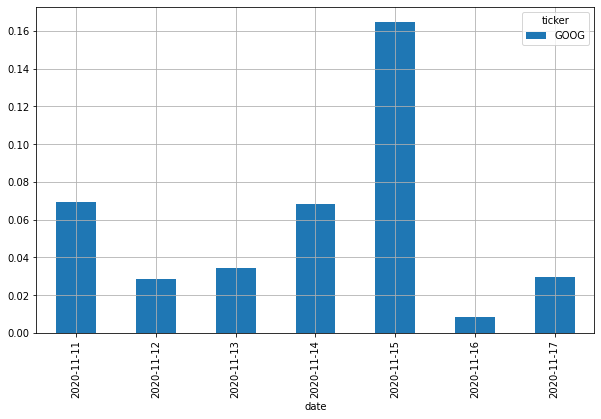

In [28]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()